# Approximating Wasserstein distances with PyTorch

Many problems in machine learning deal with the idea of making two probability distributions to be as close as possible. In the simpler case where we only have observed variables $\mathbf{x}$ (say, images of cats) coming from an unknown distribution $p(\mathbf{x})$, we'd like to find a model $q(\mathbf{x}\vert\theta)$ (like a neural network) that is a good approximation of $p(\mathbf{x})$. It can be shown<a href="#fn1" id="fr1"><sup>1</sup></a> that minimizing $\text{KL}(p\Vert q)$ is equivalent to minimizing the negative log-likelihood, which is what we usually do when training a classifier, for example. In the case of the <a href="https://dfdazac.github.io/01-vae.html" target=_blank>Variational Autoencoder</a>, we want the approximate posterior to be close to some prior distribution, which we achieve, again, by minimizing the KL divergence between them.

In spite of its wide use, there are some cases where the KL divergence simply can't be applied. Consider the following discrete distributions:

![](img/discrete.png)

The KL divergence assumes that the two distributions share the same support (that is, they are defined in the same set of points), so we can't calculate it for the example above. This and other computational aspects motivate the search for a better suited method to calculate how different two distributions are.

In this post I will

- give a brief introduction to the optimal transport problem,
- describe the Sinkhorn iterations as an approximation to the solution,
- calculate Sinkhorn distances using PyTorch,
- describe an extension of the implementation to calculate distances of mini-batches

## Moving probability masses

Let's think of discrete probability distributions as point masses scattered across the space. We could measure how much effort it would it take to move points of mass from one distribution to the other, as in this example:

![](img/assignment.png)

We can then define an alternative metric as the total effort used to move all points. We can formalize this intuitive notion by first introducing a *coupling matrix* $\mathbf{P}$ that represents how much probability mass from one point in the support of $p(x)$ is assigned to a point in the support of $q(x)$. For these uniform distributions we have that each point has a probability mass of $1/4$. If we order the points in the supports of the example from left to right, we can write the coupling matrix for the assignment shown above as:

$$
\mathbf{P} =
\begin{pmatrix}
0 & 0 & 0 & \tfrac{1}{4}\\
0 & 0 & \tfrac{1}{4} & 0\\
0 & \tfrac{1}{4} & 0 & 0\\
\tfrac{1}{4} & 0 & 0 & 0\\
\end{pmatrix}
$$

That is, mass in point 1 in the support of $p(x)$ gets assigned to point 4 in the support of $q(x)$, point 2 to point 3, and so on, as shown with the arrows above.

In order to know how much effort the assignment takes, we introduce a second matrix, known as the *distance matrix*. Each entry $\mathbf{C}_{ij}$ in this matrix contains the cost of moving point $i$ in the support of $p(x)$ to point $j$ in the support of $q(x)$. One way to define this cost is to use the Euclidian distance between points, also known as the *ground distance*. If we assume the supports for $p(x)$ and $q(x)$ are $\lbrace 1,2,3,4\rbrace$ and $\lbrace 5,6,7, 8\rbrace$, respectively, the cost matrix is:

$$
\mathbf{C} =
\begin{pmatrix}
4 & 5 & 6 & 7 \\
3 & 4 & 5 & 6 \\
2 & 3 & 4 & 5 \\
1 & 2 & 3 & 4
\end{pmatrix}
$$

With these definitions, the total cost can be calculated as the <a href="https://en.wikipedia.org/wiki/Frobenius_inner_product" target=_blank>Frobenius inner product</a> between $\mathbf{P}$ and $\mathbf{C}$:

$$
\langle\mathbf{C},\mathbf{P} \rangle = \sum_{ij}\mathbf{C}_{ij}\mathbf{P}_{ij}
$$

As you might have noticed, there are actually multiple ways to move points from one support to the other, each one yielding different costs. The one above is just one example, but we are interested in the assignment that results in the smaller cost. This is the problem of **optimal transport** between two discrete distributions, and its solution is the lowest cost $\text{L}_\mathbf{C}$ *over all possible coupling matrices*. This last condition introduces a constraint in the problem, because not any matrix is a valid coupling matrix. For a coupling matrix, all its columns must add to a vector containing the probability masses for $p(x)$, and all its rows must add to a vector with the probability masses for $q(x)$. In our example, these vectors contain 4 elements, all with a value of $1/4$. More generally, we can let these two vectors be $\mathbf{a}$ and $\mathbf{b}$, respectively, so the optimal transport problem can be written as:

$$
\begin{align*}
&\text{L}_\mathbf{C} = \min_{\mathbf{P}}\langle\mathbf{C},\mathbf{P}\rangle \\
\text{subject to } &\mathbf{P}\mathbf{1} = \mathbf{a} \\
&\mathbf{P}^{\top}\mathbf{1} = \mathbf{b}
\end{align*}
$$

When the distance matrix is based on a valid <a href="https://en.wikipedia.org/wiki/Metric_(mathematics)">distance function</a>, the minimum cost is known as the **Wasserstein distance**.

There is a large body of work regarding the solution of this problem and its extensions to continuous probability distributions. For a more formal and comprehensive account, I recommend checking the book <a href="https://arxiv.org/abs/1803.00567" target=_blank>Computational Optimal Transport</a> by Gabriel Peyré and Marco Cuturi, which is the main source for this post. 

The bottom line here is that we have framed the problem of finding the distance between two distributions as finding the optimal coupling matrix. It turns out that there is a small modification that allows us to solve this problem in an iterative and differentiable way, that will work well with automatic differentiation libraries for deep learning, like PyTorch and TensorFlow.

## Entropic regularization and the Sinkhorn iterations

We start by defining the *entropy* of a matrix:

$$
H(\mathbf{P}) = -\sum_{ij}\mathbf{P}_{ij}\log\mathbf{P}_{ij}
$$

As in the notion of <a href="https://en.wikipedia.org/wiki/Entropy_(information_theory)" target=_blank>entropy of a distribution in information theory</a>, a matrix with a low entropy will be sparser, with most of its non-zero values concentrated in a few points. Conversely, a matrix with high entropy will be smoother, with the maximum entropy achieved with a uniform distribution of values across its elements. With a regularization coefficient $\varepsilon​$, we can include this in the optimal transport problem to encourage smoother coupling matrices:

$$
\begin{align*}
&\text{L}_\mathbf{C} = \min_{\mathbf{P}}\langle\mathbf{C},\mathbf{P}\rangle -\varepsilon H(\mathbf{P})\\
\text{subject to } &\mathbf{P}\mathbf{1} = \mathbf{a} \\
&\mathbf{P}^{\top}\mathbf{1} = \mathbf{b}
\end{align*}
$$

By making $\varepsilon$ higher, the resulting coupling matrix will be smoother, and as $\varepsilon$ goes to zero it will be sparser, with the solution being close to that of the original optimal transport problem.

By introducing this entropic regularization, the optimization problem is made convex and can be solved iteratively using the *Sinkhorn iterations*<a href="#fn2" id="fr2"><sup>2</sup></a>. The solution can be written in the form $\mathbf{P} = \text{diag}(\mathbf{u})\mathbf{K}\text{diag}(\mathbf{v})$, and the iterations alternate between updating $\mathbf{u}$ and $\mathbf{v}$:

$$
\begin{align*}
\mathbf{u}^{(k+1)} &= \frac{\mathbf{a}}{\mathbf{K}\mathbf{v}^{(k)}}\\
\mathbf{v}^{(k+1)} &= \frac{\mathbf{b}}{\mathbf{K}^{\top}\mathbf{u}^{(k+1)}}
\end{align*}
$$

where $\mathbf{K}$ is a kernel matrix calculated with $\mathbf{C}$. Since these iterations are solving a regularized version of the original problem, the corresponding Wasserstein distance that results is sometimes called the Sinkhorn distance. The iterations form a sequence of linear operations, so for deep learning models it is straightforward to *backpropagate* through these iterations.

## Sinkhorn iterations with PyTorch

There are additional steps that can be added to the Sinkhorn iterations in order to improve its convergence and stability properties. We can find a clean implementation of these by Gabriel Peyrè on <a href="https://github.com/gpeyre/SinkhornAutoDiff" target=_blank>GitHub</a>. Let's test it first with a simple example.

For this, we will work now with discrete uniform distributions in 2D space (instead of 1D space as above). In this case we are moving probability masses across a plane. Let's define two simple distributions:

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
np.random.seed(42)

import torch
torch.set_printoptions(precision=3)

from layers import SinkhornDistance

from sklearn.datasets import make_moons

from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

from common import *

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
device = cpu

In [116]:
d = 2
N = 10

M = N**d

linspaces = []
for i in range(d):
    linspaces.append(np.transpose(np.linspace(state_min, state_max, N)))

meshes = np.meshgrid(*linspaces)
mesh_vectors = []
for i in range(d):
    mesh_vectors.append(meshes[i].reshape(M,1))
state = np.hstack(tuple(mesh_vectors))
state_tensor = torch.tensor(state, dtype=torch.float, requires_grad=True)

# print(state)

In [123]:
rv0 = multivariate_normal([mu_0]*d, sigma_0 * np.eye(d))
rvT = multivariate_normal([mu_T]*d, sigma_T * np.eye(d))

rho0=rv0.pdf(state)
rho0 = np.float32(rho0)

rhoT= rvT.pdf(state)
rhoT = np.float32(rhoT)

rho0_tensor = torch.from_numpy(
    rho0,
).requires_grad_(True)
rho0_tensor = rho0_tensor.to(device)

rhoT_tensor = torch.from_numpy(
    rhoT
).requires_grad_(False)
rhoT_tensor = rhoT_tensor.to(device)

# print(rho0_tensor)

sinkhorn = SinkhornDistance(eps=2.0, max_iter=100)

C = sinkhorn._cost_matrix(state_tensor, state_tensor)
# C = cdist(state, state, 'sqeuclidean')

dist, P, C = sinkhorn(C, rho0_tensor, rhoT_tensor)
print("Sinkhorn distance: {:.3f}".format(dist.item()))

dist.backward()
print("rho0_tensor.grad", rho0_tensor.grad)

Sinkhorn distance: 7.410
rho0_tensor.grad tensor([-26.678, -26.558, -26.307, -25.451, -23.537, -20.858, -17.799, -14.846,
        -12.283, -10.721, -26.558, -26.628, -26.214, -24.777, -22.274, -19.122,
        -15.368, -11.388,  -9.140,  -9.880, -26.307, -26.214, -25.108, -23.443,
        -20.958, -17.824, -13.954,  -9.427,  -4.571,  -5.356, -25.451, -24.777,
        -23.443, -21.790, -19.321, -16.197, -12.327,  -7.767,  -2.465,   2.278,
        -23.537, -22.274, -20.958, -19.321, -16.850, -13.726,  -9.855,  -5.295,
          0.033,   5.963, -20.858, -19.122, -17.824, -16.197, -13.726, -10.601,
         -6.731,  -2.170,   3.159,   9.166, -17.799, -15.368, -13.954, -12.327,
         -9.855,  -6.731,  -2.860,   1.700,   7.030,  13.041, -14.846, -11.388,
         -9.427,  -7.767,  -5.295,  -2.170,   1.700,   6.261,  11.590,  17.601,
        -12.283,  -9.140,  -4.571,  -2.465,   0.033,   3.159,   7.030,  11.590,
         16.919,  22.897, -10.721,  -9.880,  -5.356,   2.278,   5.963,   9.166

In [108]:
rv0 = multivariate_normal([1]*d, 2.0 * np.eye(d))
rvT = multivariate_normal([0]*d, sigma_T * np.eye(d))

rho0=rv0.pdf(state)
rho0 = np.float32(rho0)

rhoT=rvT.pdf(state)
rhoT = np.random.uniform(0,1,state.shape[0])
rhoT /= np.sum(rhoT)
rhoT = np.float32(rhoT)

rho0_tensor = torch.from_numpy(
    rho0,
).requires_grad_(True)
rho0_tensor = rho0_tensor.to(device)

rhoT_tensor = torch.from_numpy(
    rhoT
).requires_grad_(False)
rhoT_tensor = rhoT_tensor.to(device)

print(rho0_tensor)

sinkhorn = SinkhornDistance(eps=0.1, max_iter=100)

C = sinkhorn._cost_matrix(state_tensor, state_tensor)
# C = cdist(state, state, 'sqeuclidean')

dist, P, C = sinkhorn(C, rho0_tensor, rhoT_tensor)
print("Sinkhorn distance: {:.3f}".format(dist.item()))

dist.backward()
print("rho0_tensor.grad", rho0_tensor.grad)

tensor([1.212e-09, 4.593e-07, 7.648e-06, 5.596e-06, 1.799e-07, 4.593e-07,
        1.741e-04, 2.899e-03, 2.121e-03, 6.817e-05, 7.648e-06, 2.899e-03,
        4.827e-02, 3.531e-02, 1.135e-03, 5.596e-06, 2.121e-03, 3.531e-02,
        2.584e-02, 8.305e-04, 1.799e-07, 6.817e-05, 1.135e-03, 8.305e-04,
        2.670e-05], requires_grad=True)
Sinkhorn distance: 13.906
rho0_tensor.grad tensor([-395.457, -344.642, -189.453,  -41.212,  256.589, -344.440, -293.029,
        -137.697,    8.326,  -54.100, -189.422, -137.687,   17.665,    8.546,
          -5.617, -152.439, -112.315,    8.095,   -8.400,  -51.607, -192.245,
        -152.441,  -32.040,  -53.862, -172.404])


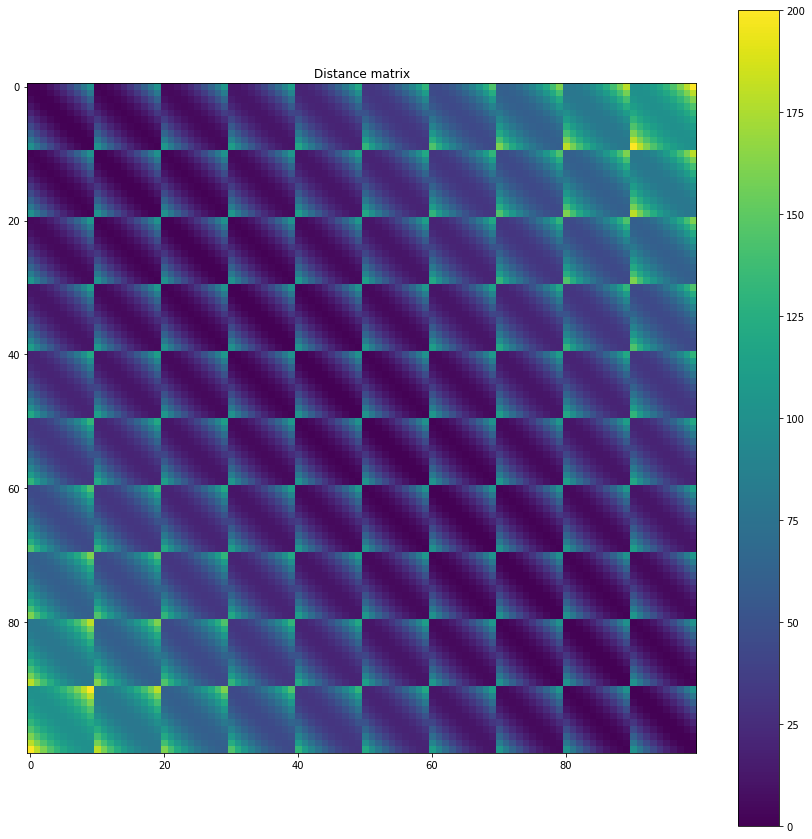

In [124]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(C.detach().numpy())
# plt.imshow(C)
plt.title('Distance matrix')
plt.colorbar();

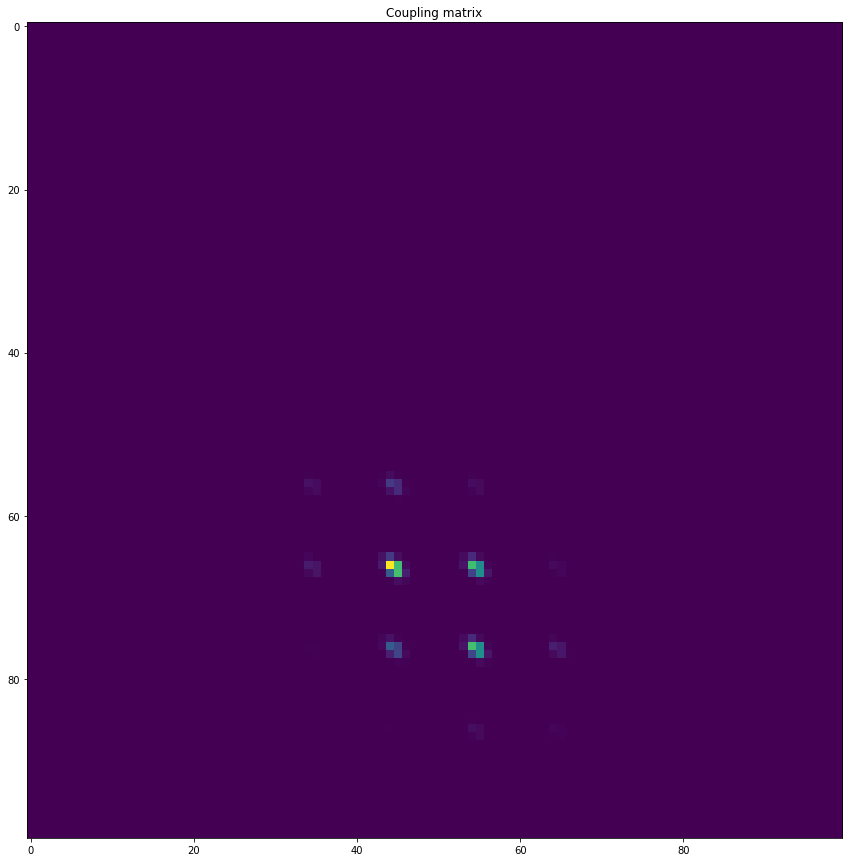

In [126]:
plt.imshow(P.detach().numpy())
plt.title('Coupling matrix');

plt.savefig('p_opt_n10.png', dpi=300)

tensor(0., grad_fn=<MinBackward1>)
tensor(0.079, grad_fn=<MaxBackward1>)
torch.Size([100, 100])


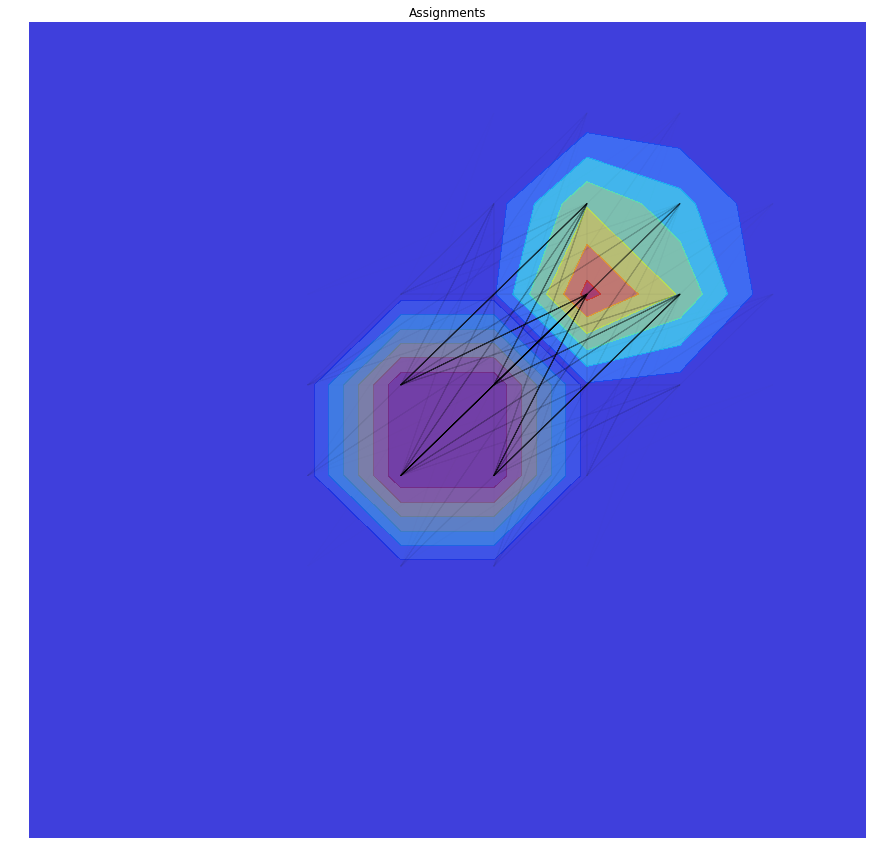

In [131]:
print(P.min())
print(P.max())
print(P.shape)

N = 10
# P_matrix = P.reshape((N, N))

plt.contourf(
    meshes[0],
    meshes[1],
    rhoT.reshape(N, N),
    cmap=cm.jet, alpha=0.5)

plt.contourf(
    meshes[0],
    meshes[1],
    rho0.reshape(N, N),
    cmap=cm.jet, alpha=0.5)


def show_assignments(state_a, state_b, P): 
    np_p = P.detach().numpy()
    norm_P = np_p/np_p.max()
    for i in range(state_a.shape[0]):
        for j in range(state_b.shape[0]):
            plt.arrow(
                state_a[i, 0],
                state_a[i, 1],
                state_b[j, 0]-state_a[i, 0],
                state_b[j, 1]-state_a[i, 1],
                alpha=norm_P[i,j].item())
    plt.title('Assignments')
#     plt.scatter(a[:, 0], a[:, 1])
#     plt.scatter(b[:, 0], b[:, 1])
    plt.axis('off')

show_assignments(state, state, P)

# plt.savefig('assignment_rho0_rhoT_n10.png', dpi=300)
plt.show()

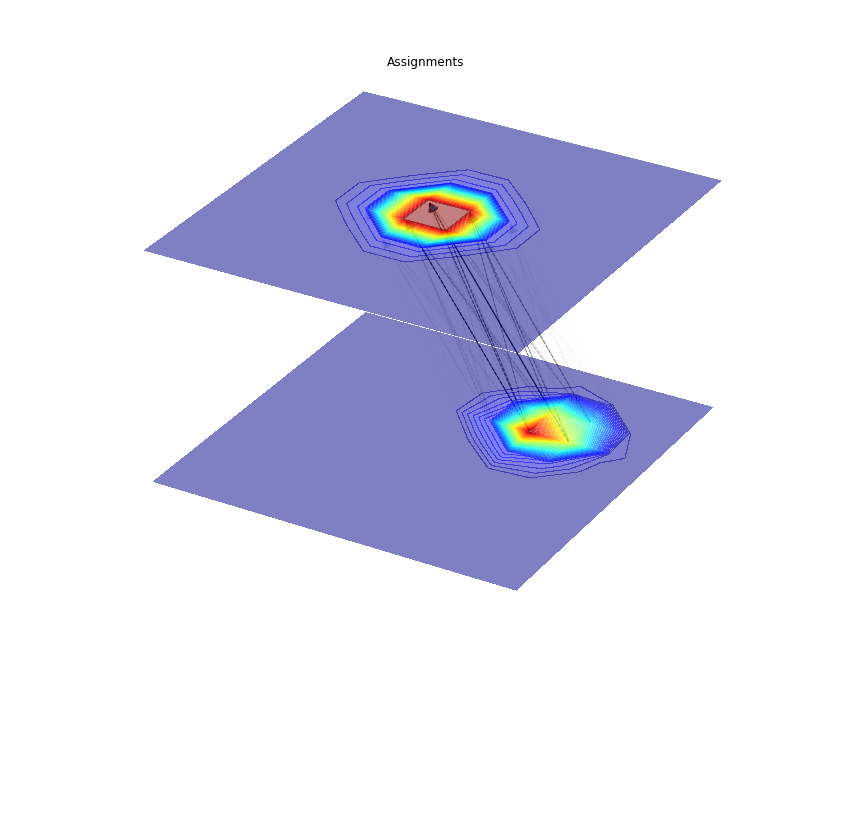

In [154]:
from mpl_toolkits import mplot3d
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)
    
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.contourf(
    meshes[0],
    meshes[1],
    rho0.reshape(N, N),
    50, zdir='z',
    cmap=cm.jet,
    offset=0.1,
    alpha=0.5
)

ax.contourf(
    meshes[0],
    meshes[1],
    rhoT.reshape(N, N),
    50, zdir='z',
    cmap=cm.jet,
    offset=0.25,
    alpha=0.5,
)

def show_assignments_3d(state_a, state_b, P): 
    np_p = P.detach().numpy()
    norm_P = np_p/np_p.max()
    for i in range(state_a.shape[0]):
        for j in range(state_b.shape[0]):
            ax.arrow3D(
                state_a[i, 0], state_a[i, 1], 0.1,
                state_b[j, 0] - state_a[i, 0],
                state_b[j, 1] - state_a[i, 1],
                0.25 - 0.1,
                alpha=norm_P[i,j].item(),
                mutation_scale=20,
                arrowstyle="-|>",
                linestyle='dashed')
    plt.title('Assignments')
    plt.axis('off')

show_assignments_3d(state, state, P)
# # Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
# ax.plot3D(xline, yline, zline, 'gray')

# # Data for three-dimensional scattered points
# zdata = 15 * np.random.random(100)
# xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
# ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
# ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

In [ ]:
n_points = 5
a = np.array([[i, 0, 0] for i in range(n_points)])
b = np.array([[i, 1, 0] for i in range(n_points)])

x = torch.tensor(a, dtype=torch.float, requires_grad=True)
y = torch.tensor(b, dtype=torch.float, requires_grad=False)

print(x.shape)

plt.figure(figsize=(6, 3))
plt.scatter(a[:, 0], a[:, 1], label='supp($p(x)$)')
plt.scatter(b[:, 0], b[:, 1], label='supp($q(x)$)')
plt.legend();

We can easily see that the optimal transport corresponds to assigning each point in the support of $p(x)$ to the point right above in the support of $q(x)$. For all points, the distance is 1, and since the distributions are uniform, the mass moved per point is 1/5. Therefore, the Wasserstein distance is $5\times\tfrac{1}{5} = 1$. Let's compute this now with the Sinkhorn iterations.

In [ ]:
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100)

C = sinkhorn._cost_matrix(x, y)

x_points = x.shape[-2]
y_points = y.shape[-2]
if x.dim() == 2:
    batch_size = 1
else:
    batch_size = x.shape[0]

# both marginals are fixed with equal weights
mu = torch.empty(batch_size, x_points, dtype=torch.float,
    requires_grad=False)\
    .fill_(1.0 / x_points).squeeze()
nu = torch.empty(batch_size, y_points, dtype=torch.float,
    requires_grad=False)\
    .fill_(1.0 / y_points).squeeze()

print('mu', mu.shape)
print('nu', nu)

dist, P, C = sinkhorn(C, mu, nu)
print("Sinkhorn distance: {:.3f}".format(dist.item()))

Just as we calculated. Now, it would be very interesting to check the matrices returned by the `sinkhorn()` method: `P`, the calculated coupling matrix, and `C`, the distance matrix. Let's begin with the distance matrix:

In [ ]:
fig1 = plt.figure()
ax1=fig1.gca(projection='3d')
sc1=ax1.scatter(mesh_vectors[0], mesh_vectors[1], mesh_vectors[2], c=v, cmap=plt.hot())
plt.colorbar(sc1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

In [ ]:
plt.imshow(C.detach().numpy())
# plt.imshow(C)
plt.title('Distance matrix')
plt.colorbar();

The entry `C[0, 0]` shows how moving the mass in $(0, 0)$ to the point $(0, 1)$ incurs in  a cost of 1. At the other end of the row, the entry `C[0, 4]` contains the cost for moving the point in $(0, 0)$ to the point in $(4, 1)$. This is the larger cost in the matrix:

$$
(4 - 0)^2 + (1 - 0)^2 = 17
$$

since we are using the squared $\ell^2$-norm for the distance matrix.

Let's now take a look at the calculated coupling matrix:

In [ ]:
sinkhorn2 = SinkhornDistance(eps=1, max_iter=100, reduction=None)



print("Sinkhorn distance: {:.3f}".format(dist.item()))

plt.imshow(P.detach().numpy())
plt.title('Coupling matrix');

This readily shows us how the algorithm effectively found that the optimal coupling is the same one we determined by inspection above.

So far we have used a regularization coefficient of 0.1. What happens if we increase it to 1?

In [ ]:
dist.backward()
print(x.grad)

As we discussed, increasing $\varepsilon$ has the effect of increasing the entropy of the coupling matrix. Here we see how $\mathbf{P}$ has become smoother, but also that there is a detrimental effect on the calculated distance, and the approximation to the true Wasserstein distance worsens.

It's also interesting to visualize the assignments in the space of the supports:

In [ ]:
def show_assignments(a, b, P):    
    norm_P = P/P.max()
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            plt.arrow(
                a[i, 0],
                a[i, 1],
                b[j, 0]-a[i, 0],
                b[j, 1]-a[i, 1],
                alpha=norm_P[i,j].item())
    plt.title('Assignments')
    plt.scatter(a[:, 0], a[:, 1])
    plt.scatter(b[:, 0], b[:, 1])
    plt.axis('off')

show_assignments(a, b, P)

Let's do this for a more interesting distribution: the Moons dataset.

In [ ]:

X, Y = make_moons(n_samples = 30)
a = X[Y==0]
b = X[Y==1]

x = torch.tensor(a, dtype=torch.float, requires_grad=True)
y = torch.tensor(b, dtype=torch.float, requires_grad=False)

sinkhorn = SinkhornDistance(eps=0.1, max_iter=100)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))
show_assignments(a, b, P)

dist.backward()

print(x.grad)

## Mini-batch Sinkhorn distances

In deep learning, we are usually interested in working with mini-batches to speed up computations. The Sinkhorn iterations can be adapted to this setting by modifying them with the additional batch dimension. After adding this change to the implementation (code <a href="https://github.com/dfdazac/wassdistance/blob/master/layers.py" target=_blank>here</a>), we can compute Sinkhorn distances for multiple distributions in a mini-batch. Let's do it here for another example that is easy to verify.

We will compute Sinkhorn distances for 4 pairs of uniform distributions with 5 support points, separated vertically by 1 (as above), 2, 3, and 4 units. This way, the Wasserstein distances between them will be 1, 4, 9 and 16, respectively.

In [ ]:
n = 5
batch_size = 4
a = np.array([[[i, 0] for i in range(n)] for b in range(batch_size)])
b = np.array([[[i, b + 1] for i in range(n)] for b in range(batch_size)])

# Wrap with torch tensors
x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)

sinkhorn = SinkhornDistance(eps=0.1, max_iter=100)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distances: ", dist)

It works! Note also that now `P` and `C` are 3D tensors, containing the coupling and distance matrices for each pair of distributions in the mini-batch:

In [ ]:
print('P.shape = {}'.format(P.shape))
print('C.shape = {}'.format(C.shape))

## Conclusion

The notion of the Wasserstein distance between distributions and its calculation via the Sinkhorn iterations open up many possibilities. The framework not only offers an alternative to distances like the KL divergence, but provides more flexibility during modeling, as we are no longer forced to choose a particular parametric distribution. The iterations can be executed efficiently on GPU and are fully differentiable, making it a good choice for deep learning. These advantages have been exploited in recent works in machine learning, such as autoencoders<sup>3,4</sup> and metric embedding<sup>5,6</sup>, making it promising for further applications in the field.

#### Acknowledgments

I'd like to thank Thomas Kipf for introducing me to the problem of optimal transport and insightful discussions; and Gabriel Peyrè for making code resources available online.

#### References

<ol>
    <li id="fn1">See C. Bishop, *Pattern Recognition and Machine Learning*, section 1.6.1. <a href="#fr1">↩</a></li>
    <li id="fn2">Cuturi, Marco. "Sinkhorn distances: Lightspeed computation of optimal transport." Advances in neural information processing systems, 2013. <a href="#fr2">↩</a></li>
    <li>Tolstikhin, Ilya, et al. "Wasserstein auto-encoders." arXiv preprint arXiv:1711.01558, 2017.</li>
    <li>Patrini, Giorgio, et al. "Sinkhorn AutoEncoders." arXiv preprint arXiv:1810.01118, 2018.</li>
    <li>Courty, Nicolas, Rémi Flamary, and Mélanie Ducoffe. "Learning wasserstein embeddings." arXiv preprint arXiv:1710.07457, 2017.</li>
    <li>Charlie Frogner, Farzaneh Mirzazadeh, Justin Solomon. "Learning Embeddings into Entropic Wasserstein Spaces." ICLR (2019).</li>
</ol>